## Preprocess Raw Data

In [9]:
import pandas as pd
import numpy as np
import json
from IPython.display import display
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#method used to read the specified json sub-table from the json file. player data, team data 
#returns the sub table as a dataframe 
def read_column_data(raw_json,column_name):

    return pd.io.json.json_normalize(raw_json,record_path=column_name+'s'
          ,meta=['date','duration','mapId'],record_prefix=column_name+'_')


#method and trick used to reformat the dataframe of the raw json file to a 
# new json file so our json normalizer can read it properly.
#returns a json file
def fix_json_format(json_df):
    new_json=json_df.to_json(orient='records',date_unit='s')
    return json.loads(new_json)

#method used to read the raw json file
#returns a dataframe of the raw json file
def read_raw_file(raw_json):
     return pd.io.json.json_normalize(raw_json)
    
    
#combines previous methods to read the raw data, saves it to a pickle file, print basic stats
#returns the 3 tables as dataframes
def read_json_files(file_name,print_stats=False):
    
    json_df=pd.read_json(file_name,orient='index')
    new_json=fix_json_format(json_df)
    
    raw_data=read_raw_file(new_json)
    
    player_data=read_column_data(new_json,'player')
    
    team_data=read_column_data(new_json,'team')
    
    save_data(raw_data,'raw_data.p')
    save_data(player_data,'player_data.p')
    save_data(team_data,'team_data.p')
    
    if print_stats:
        print('data date range',json_df['date'].min(),' - ',json_df['date'].max())
        print('# of records in raw data',raw_data.shape[0])
        
        
        print('# of records in player data',player_data.shape[0])
        print('# of unique players',player_data['player_name'].nunique())
        
        
        print('# of records in team data',team_data.shape[0])
        
        display(raw_data.head(3))
        display(player_data.head(3))
        display(team_data.head(3))  
        
    return raw_data,player_data,team_data
#method used to add a 'win' column based on the team table.
#returns dataframe with the 'win' column
def add_team_win_column(team_data):
   
    group_team_data=team_data.groupby(['date','duration','mapId'],as_index=False).sum()
    team_data['win']=0
    #print(group_team_data)
    for index, row in tqdm(group_team_data.iterrows()):
        #print(x)
        date=row['date']
        duration=row['duration']
        mapId=row['mapId']

        tm1_filter=(team_data['date']==date)&(team_data['duration']==duration)&(team_data['mapId']==mapId)&(team_data['player_team']==1)
        tm2_filter=(team_data['date']==date)&(team_data['duration']==duration)&(team_data['mapId']==mapId)&(team_data['player_team']==2)
        
        team_1=team_data.loc[tm1_filter]
        team_2=team_data.loc[tm2_filter]
        #print(row['date'])
        if not (team_1.empty):
            if not (team_2.empty):
                tm1=team_1['team_score'].values[0]
                tm2=team_2['team_score'].values[0]

                if tm1> tm2: 
                    team_data.loc[tm1_filter,'win']=1
                elif tm1< tm2: 
                    team_data.loc[tm2_filter,'win']=1
    return team_data
#method used to convert team name to a number, to match player data's 'team' column
#returns team data with renamed player_team and new 'win' column
def transform_team_data(team_data):
    #convert team name to match player data team
    team_data['player_team'] = 1
    team_data.loc[1::2,"player_team"] = 2
    
    return add_team_win_column(team_data)
#method used to transform our team data and merge the 2-3 dataframes
#returns merged dataframe
def transform_and_merge_data(raw_data,player_data,team_data,include_team=False):
 
    raw_data.reset_index(inplace=True)
    
    if include_team:
        team_data=transform_team_data(team_data)
        
    result = pd.merge(raw_data, player_data, how='inner', on=['date','duration','mapId'])
    
    if include_team:
        result = pd.merge(result, team_data, how='left', on=['date','duration','mapId','player_team'])
        
        result['team_score'].fillna(value=0,inplace=True)
        result['win'].fillna(value=0,inplace=True)
    
    result['date']=result['date'].astype('object')
    result['date'] =pd.to_datetime(result['date'],unit='s',infer_datetime_format=True)
    result=result.sort_values(['date','player_name'])
    return result
#method used to drop specified columns
#returns dataframe without the columns
def drop_columns(data,col_to_drop,include_team=False):
    data.drop(col_to_drop,axis=1,inplace=True)
    if include_team:
        data.drop(['team_name','team_splats'],axis=1,inplace=True)
    return data

# method used to save data to the specfied pickle file
def save_data(data,name):
    pickle.dump(data,open(name,'wb'))    
    
# method used to combine all previous methods to automatically preprocess our file
# returns resulting dataframe
def preprocess_data(columns_to_drop,include_team=True):
    raw_data,player_data,team_data=read_json_files('bulkmatches.json',False)
    result=transform_and_merge_data(raw_data,player_data,team_data,include_team)
    result=drop_columns(result,columns_to_drop,include_team)
    name='processed_raw_data'
    if include_team:
        name=name+'_with_team'
    
    save_data(result,name+'.p')
    return result

## Preprocess our raw data

In [7]:
#immediate data preprocessing
columns_to_drop=[
    'port','players','official','player_auth','official','finished','server','finished','group','timeLimit',
    'teams','player_events','player_flair','mapId','player_team']
result=preprocess_data(columns_to_drop,include_team=False)
result_w_team=preprocess_data(columns_to_drop,include_team=True)
display(result.head(3))
display(result_w_team.head(3))

27127it [03:07, 144.68it/s]


,index,date,duration,player_degree,player_name,player_points,player_score
2,0,2015-05-25 17:49:57,22562,31,2Pop,29,19
6,0,2015-05-25 17:49:57,22562,89,Android,31,50
1,0,2015-05-25 17:49:57,22562,0,BartimaeusJr,0,56


,index,date,duration,player_degree,player_name,player_points,player_score,team_score,win
2,0,2015-05-25 17:49:57,22562,31,2Pop,29,19,3.0,1.0
6,0,2015-05-25 17:49:57,22562,89,Android,31,50,3.0,1.0
1,0,2015-05-25 17:49:57,22562,0,BartimaeusJr,0,56,3.0,1.0


## Reason for selecting Regression/Classification:

**Answer: Classification
Reason:**

Pros:
1. Time constraint
    - Working on a regression problem adds a layer of complexity in terms of computation and parameter tuning
2. A months' worth of data
    - Having a months worth of data can be difficult to work with especially if we want our model to produce decent results. Its even harder when trying to work on regression/time-series.
    - Use case wise, a new game would have more luck working on a classification problem when data is limited.(say the game just released a week ago)
    - Regression can make identifying and defining churners a bit more difficult

Cons:
1. Churned users may not really be churned users. Churned users would be dependent on the range provided.


In [21]:
raw_data,player_data,team_data=read_json_files('bulkmatches.json',True)

data date range 2015-05-25 17:49:57  -  2015-06-20 05:42:38
# of records in raw data 27127
# of records in player data 229742
# of unique players 14629
# of records in team data 54254


,date,duration,finished,group,mapId,official,players,port,server,teams,timeLimit
0,1432576197,22562,1,,6,1,"[{'auth': True, 'name': 'RoDyMaRy', 'flair': 1...",8008,tagpro-chord.koalabeast.com,"[{'name': 'Red', 'score': 1, 'splats': 'mp59z/...",12
1,1433101992,7202,1,redacted,17,1,"[{'auth': True, 'name': 'DUSTY', 'flair': 105,...",8001,tagpro-orbit.koalabeast.com,"[{'name': 'Red', 'score': 1, 'splats': 'q9Mtq8...",2
2,1433885981,6100,1,,24,1,"[{'auth': True, 'name': 'Roll Player', 'flair'...",8008,tagpro-radius.koalabeast.com,"[{'name': 'Red', 'score': 3, 'splats': 'm0Uqis...",12


,player_auth,player_degree,player_events,player_flair,player_name,player_points,player_score,player_team,date,duration,mapId
0,True,99,AREVYIpPCAe0QCBSIAisARCvARK/ARCjARArIAgDARAfAR...,105,RoDyMaRy,25,31,1,1432576197,22562,6
1,True,0,AiIApQCKggCIqwCI5wCIMwEIPABQlABRGwBUlQgE3ECgKg...,86,BartimaeusJr,0,56,2,1432576197,22562,6
2,True,31,QBCUIAk3ARI8ARCjAFErCASzQKBTARHAARGTCAdbQCDKQB...,104,2Pop,29,19,2,1432576197,22562,6


,team_name,team_score,team_splats,date,duration,mapId
0,Red,1,mp59z/DaK5eWsvU1WURi5P0ufn/XUS4TVqOBt9RPBWsOip...,1432576197,22562,6
1,Blue,3,psKLSdkU5Ql2Mj1JaTciTKnUgn4nLT/TWKiVq85VLOXqar...,1432576197,22562,6
2,Red,1,q9Mtq8slpC35lbK1i/VLlHKal6Kh,1433101992,7202,17


In [22]:
include_team=True
result=transform_and_merge_data(raw_data,player_data,team_data,include_team)

27127it [03:20, 133.01it/s]


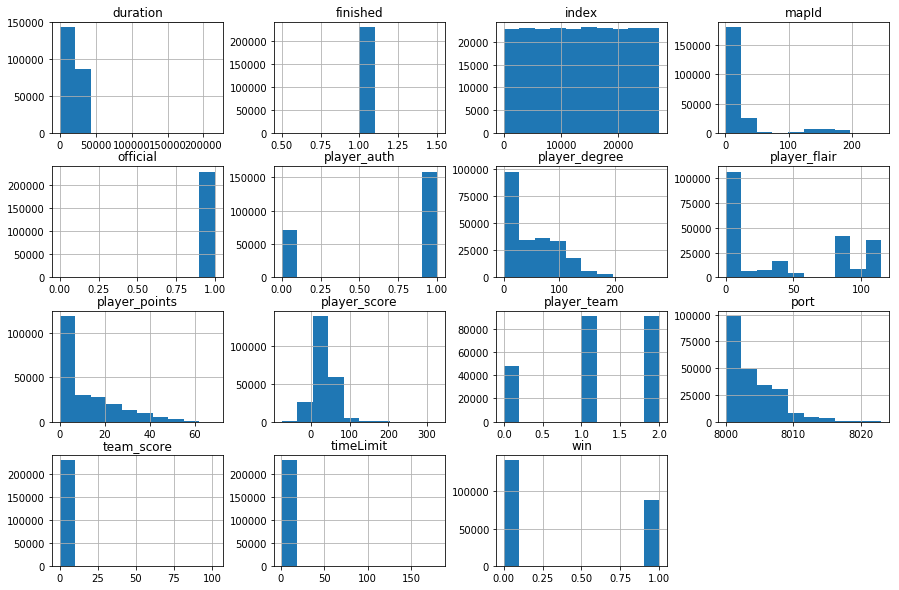

In [23]:
result.hist(figsize=(15,10));

In [24]:
result.describe()

,index,duration,finished,mapId,official,port,timeLimit,player_degree,player_flair,player_points,player_score,player_team,team_score,win
count,229742.000000,229742.000000,229742.0,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000,229742.000000
mean,13566.131922,19785.058239,1.0,28.696468,0.992209,8003.939819,11.619047,49.440041,41.907718,10.892732,34.513197,1.184986,1.625902,0.382063
std,7830.300112,11022.492668,0.0,45.313064,0.087924,3.558973,1.617046,48.287666,43.587451,13.464820,23.154985,0.754952,2.339379,0.485893
min,0.000000,61.000000,1.0,1.000000,0.000000,8000.000000,1.000000,0.000000,0.000000,0.000000,-75.000000,0.000000,0.000000,0.000000
25%,6779.000000,10775.000000,1.0,7.000000,1.000000,8001.000000,12.000000,0.000000,0.000000,0.000000,20.000000,1.000000,0.000000,0.000000
50%,13576.000000,17578.000000,1.0,14.000000,1.000000,8003.000000,12.000000,42.000000,25.000000,5.000000,33.000000,1.000000,1.000000,0.000000
75%,20337.000000,28530.000000,1.0,25.000000,1.000000,8006.000000,12.000000,86.000000,87.000000,19.000000,48.000000,2.000000,3.000000,1.000000
max,27126.000000,216003.000000,1.0,246.000000,1.000000,8023.000000,180.000000,280.000000,115.000000,69.000000,326.000000,2.000000,102.000000,1.000000


In [6]:
result.isnull().sum()

index            0
date             0
duration         0
finished         0
group            0
server           0
timeLimit        0
player_degree    0
player_name      0
player_points    0
player_score     0
dtype: int64

In [ ]:
columns_to_drop=[
    'port','players','official','player_auth','official','finished','server','finished','group','timeLimit',
    'teams','player_events','player_flair','mapId','player_team']
result=drop_columns(result,columns_to_drop,include_team)
display(result)

name='processed_raw_data'
if include_team:
    name=name+'_with_team'
    
save_data(result,name+'.p')